In this notebook we will be building and training LSTM to predict IBM stock. We will use PyTorch.

## 1. Libraries and settings

In [2]:
import numpy as np
import random
import pandas as pd 
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

from pandas import datetime
import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for i, filename in enumerate(filenames):
        if i<5:
            print(os.path.join(dirname,filename))


/tmp/ipykernel_15997/1682699617.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
/tmp/ipykernel_15997/1682699617.py:9: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime
/home/henrytsui/anaconda3/envs/IDS/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Load data

In [2]:
def stocks_data(symbols, dates):
    df = pd.DataFrame(index=dates)
    for symbol in symbols:
        df_temp = pd.read_csv("../input/Data/Stocks/{}.us.txt".format(symbol), index_col='Date',
                parse_dates=True, usecols=['Date', 'Close'], na_values=['nan'])
        df_temp = df_temp.rename(columns={'Close': symbol})
        df = df.join(df_temp)
    return df

In [4]:
df = pd.read_csv("../data/predict_value.csv",index_col=0)
df.head()

,meta,goog,amzn,nflx,aapl,meta_pred,goog_pred,amzn_pred,nflx_pred,aapl_pred,meta_lstm,goog_lstm,amzn_lstm,nflx_lstm,aapl_lstm
Date,,,,,,,,,,,,,,,
2020-11-30,276.97,88.0370,158.4020,490.70,117.6378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-01,286.55,89.9050,161.0040,504.58,121.2643,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-02,287.52,91.3975,160.1765,503.38,121.6200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-03,281.85,91.3385,159.3365,497.52,121.4817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-04,279.70,91.3995,158.1290,498.31,120.7999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
scaler = MinMaxScaler(feature_range=(-1, 1))
df['aapl'] = scaler.fit_transform(df['aapl'].values.reshape(-1,1))
#df_ibm

In [7]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data);
    data = np.expand_dims(data, axis=2)
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)
    print(data.shape)
    
    x_train = data[:train_set_size,:-1]
    y_train = data[:train_set_size,-1]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1]
    
    return [x_train, y_train, x_test, y_test]

look_back = 60 # choose sequence length
x_train, y_train, x_test, y_test = load_data(df["aapl"], look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

(457, 60, 1)
x_train.shape =  (366, 59, 1)
y_train.shape =  (366, 1)
x_test.shape =  (91, 59, 1)
y_test.shape =  (91, 1)


In [8]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [9]:
y_train.size(),x_train.size()

(torch.Size([366, 1]), torch.Size([366, 59, 1]))

## 3. Build the structure of model

In [10]:
# Build model
#####################
input_dim = 1
hidden_dim = 32
num_layers = 2 
output_dim = 1


# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out
    
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.1)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


In [11]:
# Train model
#####################
num_epochs = 200
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1  

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.3692432641983032
Epoch  20 MSE:  0.2522711157798767
Epoch  30 MSE:  0.25777533650398254
Epoch  40 MSE:  0.25381577014923096
Epoch  50 MSE:  0.22905032336711884
Epoch  60 MSE:  0.05920036509633064
Epoch  70 MSE:  0.03427790477871895
Epoch  80 MSE:  0.020015690475702286
Epoch  90 MSE:  0.012092416174709797
Epoch  100 MSE:  0.007109254598617554
Epoch  110 MSE:  0.0074752140790224075
Epoch  120 MSE:  0.006732437293976545
Epoch  130 MSE:  0.006619538180530071
Epoch  140 MSE:  0.006592410616576672
Epoch  150 MSE:  0.006568965967744589
Epoch  160 MSE:  0.006557379383593798
Epoch  170 MSE:  0.006549099925905466
Epoch  180 MSE:  0.0065423594787716866
Epoch  190 MSE:  0.006536973174661398


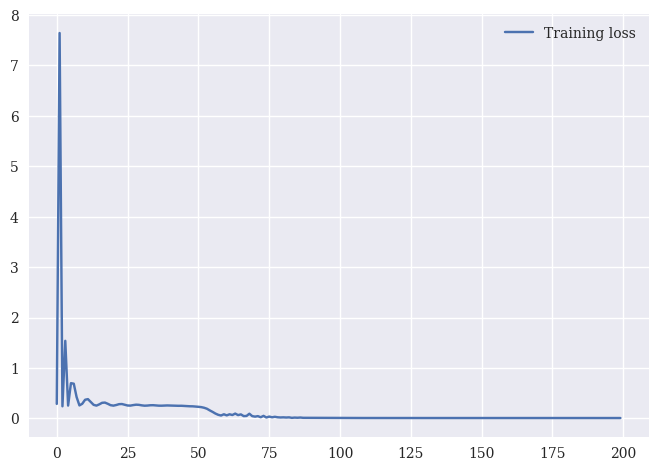

In [12]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [13]:
np.shape(y_train_pred)

torch.Size([366, 1])

In [14]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.08 RMSE
Test Score: 0.11 RMSE


In [28]:
for name in df.columns[:5]:
    print(name)
    df[f"{name}_lstm"] = np.nan

meta
goog
amzn
nflx
aapl


In [26]:
df = pd.read_csv("../data/predict_value.csv",index_col=0)


In [32]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back):
    data_raw = stock # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data)
    
    return data[:, :-1, :]
for name in df.columns[:5]:
    look_back = 60 # choose sequence length
    dfp = scaler.fit_transform(df[name].values.reshape(-1,1))
    dfp = load_data(dfp, look_back)
    dfp = torch.from_numpy(dfp).type(torch.Tensor)
    print(dfp.shape)
    y_test_pred = model(dfp)
    y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())[:,0]
    print(name, y_test_pred.shape)
    df[f"{name}_lstm"].iloc[-457:]=np.round(y_test_pred,3)
    df = df.round(3)
df.to_csv("../data/predict_value.csv")

torch.Size([457, 59, 1])
meta (457,)
torch.Size([457, 59, 1])
goog (457,)
torch.Size([457, 59, 1])
amzn (457,)
torch.Size([457, 59, 1])
nflx (457,)
torch.Size([457, 59, 1])
aapl (457,)


In [31]:
df[f"{name}_lstm"].iloc[-457:]

Date
2021-02-26    123.692
2021-03-01    120.794
2021-03-02    121.010
2021-03-03    125.408
2021-03-04    123.200
               ...   
2022-12-12    142.968
2022-12-13    142.144
2022-12-14    144.807
2022-12-15    145.520
2022-12-16    143.110
Name: aapl_lstm, Length: 457, dtype: float64

In [24]:
for name in df.columns[:5]:
    df[f"{name}_lstm"].iloc[-457:] = np.round(y_test_pred,3)
    print(df[f"{name}_lstm"].iloc[-457:])
    


Date
2021-02-26   -0.740
2021-03-01   -0.829
2021-03-02   -0.822
2021-03-03   -0.688
2021-03-04   -0.755
              ...  
2022-12-12   -0.155
2022-12-13   -0.180
2022-12-14   -0.099
2022-12-15   -0.077
2022-12-16   -0.150
Name: meta_lstm, Length: 457, dtype: float64
Date
2021-02-26   -0.740
2021-03-01   -0.829
2021-03-02   -0.822
2021-03-03   -0.688
2021-03-04   -0.755
              ...  
2022-12-12   -0.155
2022-12-13   -0.180
2022-12-14   -0.099
2022-12-15   -0.077
2022-12-16   -0.150
Name: goog_lstm, Length: 457, dtype: float64
Date
2021-02-26   -0.740
2021-03-01   -0.829
2021-03-02   -0.822
2021-03-03   -0.688
2021-03-04   -0.755
              ...  
2022-12-12   -0.155
2022-12-13   -0.180
2022-12-14   -0.099
2022-12-15   -0.077
2022-12-16   -0.150
Name: amzn_lstm, Length: 457, dtype: float64
Date
2021-02-26   -0.740
2021-03-01   -0.829
2021-03-02   -0.822
2021-03-03   -0.688
2021-03-04   -0.755
              ...  
2022-12-12   -0.155
2022-12-13   -0.180
2022-12-14   -0.099
2022-

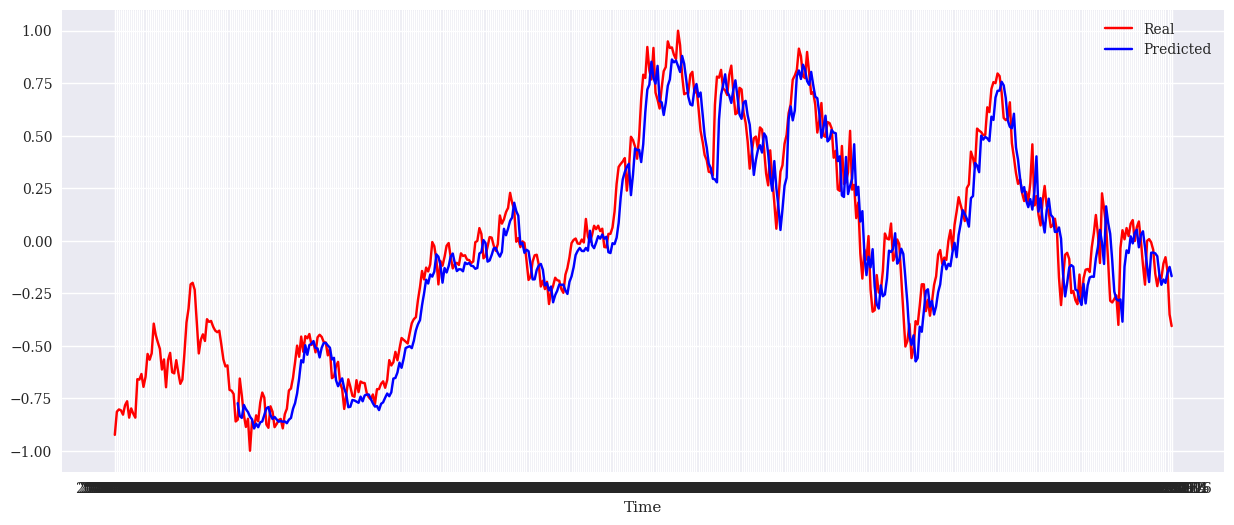

In [80]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(df["aapl"].index, df["aapl"], color = 'red', label = 'Real')
axes.plot(df["aapl"].index[60:], y_test_pred, color = 'blue', label = 'Predicted')
#axes.xticks(np.arange(0,394,50))
plt.xlabel('Time')
plt.legend()
plt.show()